In [19]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
import seaborn as sns


In [10]:
path = 'D:\Project\Earthquake\DataSet\DATASET.csv'
df = pd.read_csv(path)

In [12]:

ndt = df[['time','latitude', 'longitude']]
ndt = ndt[(ndt['latitude'] <= 30.449) & (ndt['latitude'] >= -15.284) & (ndt['longitude'] >= 80.97) & (ndt['longitude'] <= 156.797)]
ndt.head()


,time,latitude,longitude
5,1950-09-25 23:16:03,9.864,126.264
6,1950-09-26 19:06:10,24.157,122.875
8,1950-09-28 03:29:39,23.095,121.481
13,1950-09-30 07:29:00,28.873,94.409
17,1950-10-03 23:01:58,27.161,97.508


In [13]:

date_time = pd.to_datetime(ndt.pop('time'), format='%Y-%m-%d %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

ndt['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
ndt['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
ndt['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
ndt['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

ndt.head()

,latitude,longitude,Day sin,Day cos,Year sin,Year cos
5,9.864,126.264,-0.190595,0.981669,-0.994477,-0.104957
6,24.157,122.875,-0.958613,0.284713,-0.995868,-0.090807
8,23.095,121.481,0.792423,0.609972,-0.997708,-0.067663
13,28.873,94.409,0.925541,-0.378649,-0.999536,-0.030445
17,27.161,97.508,-0.250521,0.968111,-0.999478,0.032298


This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important.
https://www.tensorflow.org/tutorials/structured_data/time_series

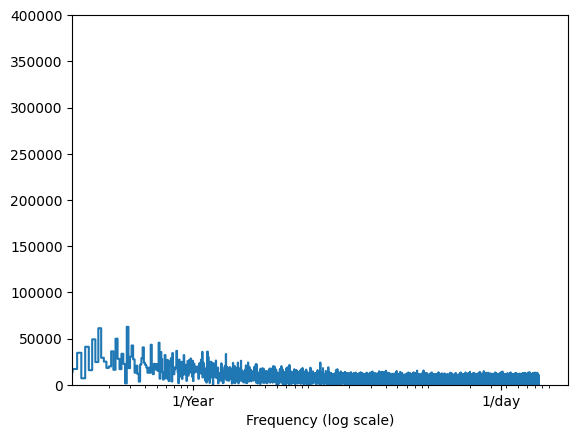

In [14]:
fft = tf.signal.rfft(ndt['latitude'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['latitude'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

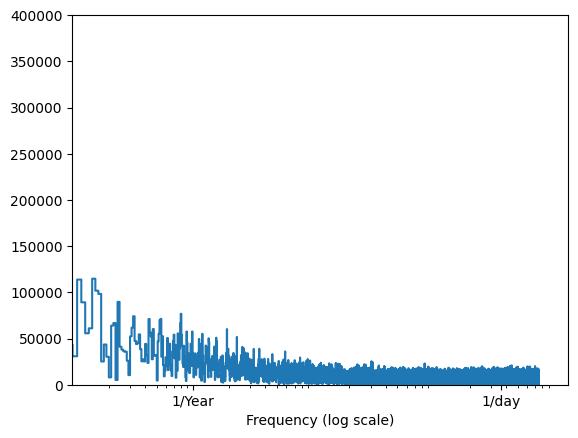

In [15]:
fft = tf.signal.rfft(ndt['longitude'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['longitude'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

Split the data
use (70,20,10)

In [16]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(ndt)
train_df = ndt[0:int(n*0.7)]
val_df = ndt[int(n*0.7):int(n*0.9)]
test_df = ndt[int(n*0.9):]

num_features = df.shape[1]

Normalize the data

In [17]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of labels (8).

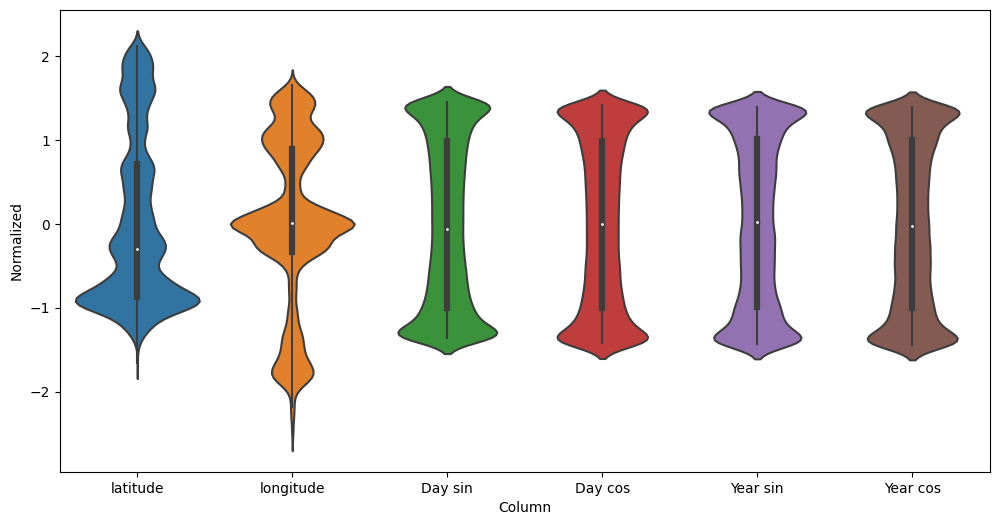

In [21]:
df_std = (ndt - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [24]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [25]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['latitude'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['latitude']

In [26]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['latitude'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['latitude']

In [27]:
w3 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['longitude'])
w3

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['longitude']

In [28]:
w4 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['longitude'])
w4

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['longitude']

In [29]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [30]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 6)
Inputs shape: (3, 6, 6)
Labels shape: (3, 1, 1)


In [31]:
w2.example = example_inputs, example_labels
w4.example = example_inputs, example_labels

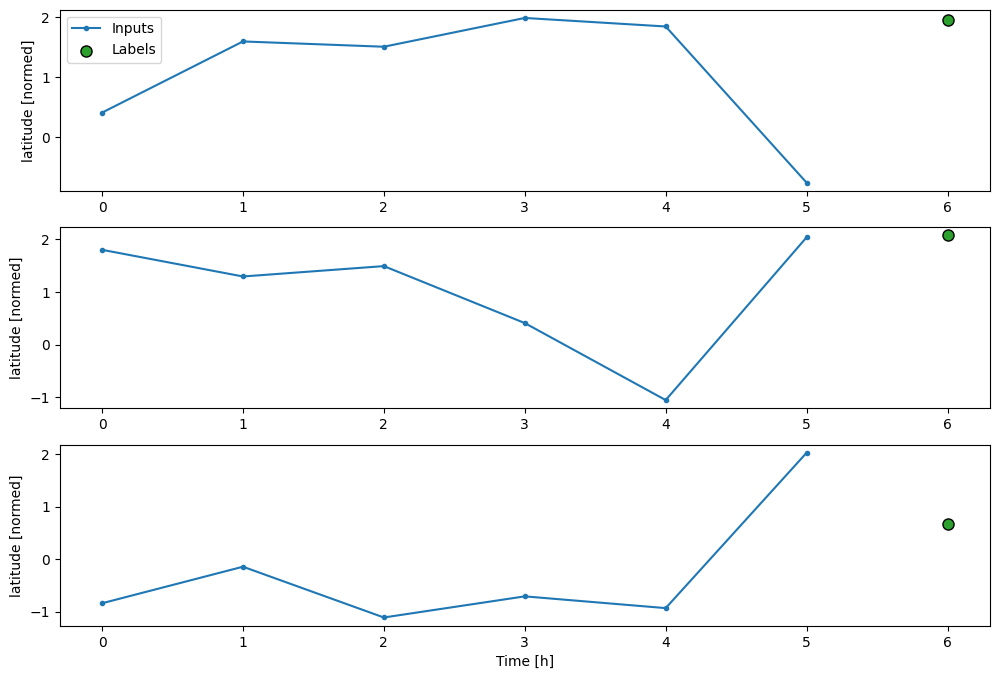

In [36]:
def plot(self, model=None, plot_col='latitude', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

w2.plot()

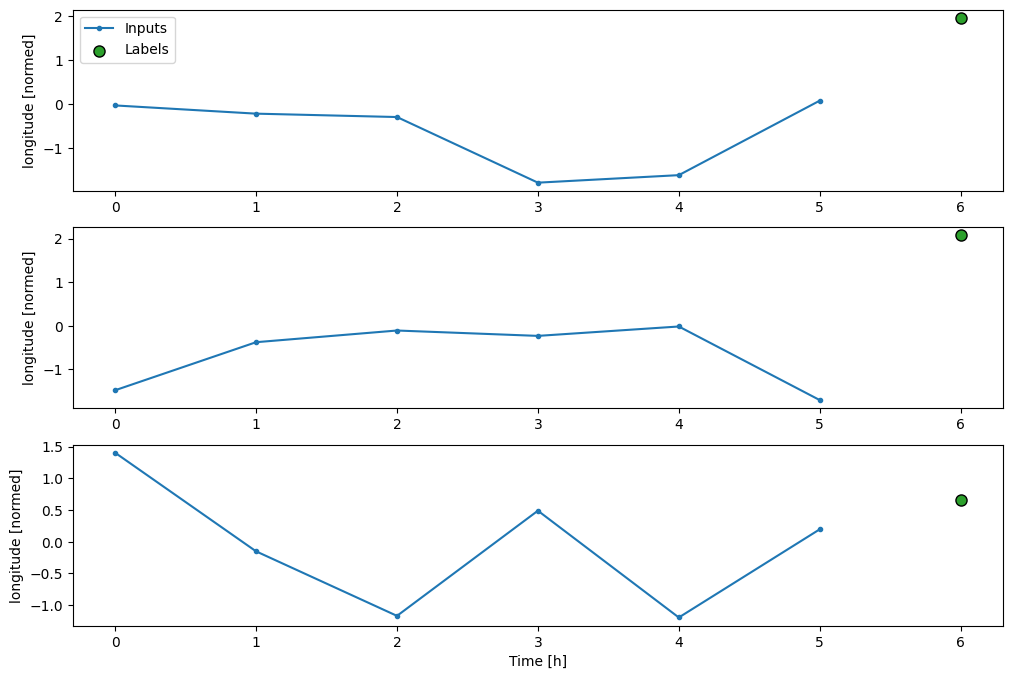

In [39]:
w4.plot(plot_col='longitude')

In [40]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [41]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [42]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 6), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [43]:
w4.train.element_spec

(TensorSpec(shape=(None, 6, 6), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [45]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'W2 Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'W2 Labels shape (batch, time, features): {example_labels.shape}')

for example_inputs, example_labels in w4.train.take(1):
  print(f'W4 Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'W4 Labels shape (batch, time, features): {example_labels.shape}')

W2 Inputs shape (batch, time, features): (32, 6, 6)
W2 Labels shape (batch, time, features): (32, 1, 1)
W4 Inputs shape (batch, time, features): (32, 6, 6)
W4 Labels shape (batch, time, features): (32, 1, 1)


In [47]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['latitude'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['latitude']

In [48]:
single_step_window1 = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['longitude'])
single_step_window1

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['longitude']

In [49]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [50]:
baseline = Baseline(label_index=column_indices['latitude'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

1022/1022 [==============================] - 3s 2ms/step - loss: 2.0562 - mean_absolute_error: 1.1757


In [51]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['latitude'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['latitude']

In [52]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 6)
Output shape: (32, 24, 1)


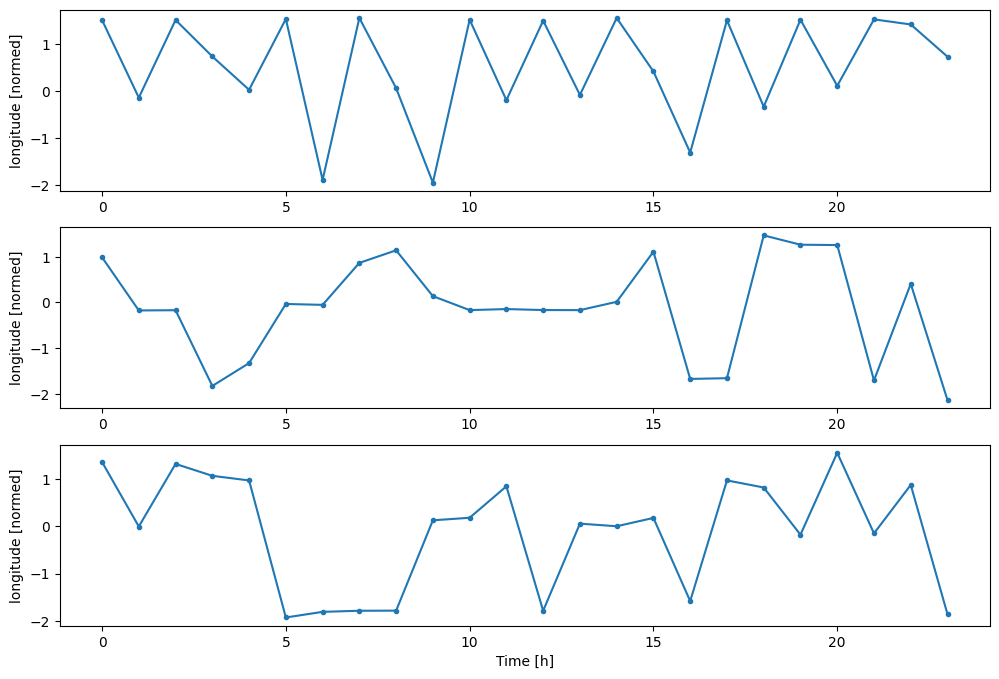

In [53]:
wide_window.plot(baseline)